In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

## Aim

**TODO**

## Data

First load the dataset:

In [2]:
from data_utils import get_mnist

train_dataset, test_dataset = get_mnist(normalize=True)

In [3]:
train_dataset.data.mean(), train_dataset.data.std()

(tensor(-6.2281e-10), tensor(0.9563))

In [4]:
train_dataset.data.min(), train_dataset.data.max()

(tensor(-1.2742), tensor(244.9449))

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Setup

Below one can find flags that will setup the notebook:

In [6]:
# Whether to tune the hyperparameters in this notebook
# Note that this might take a long time (especially for Adam)
hyperparameter_tune_minibatch = False
hyperparameter_tune_nesterov = False
hyperparameter_tune_adam = False
prot_hyperparameter_tune = False

In [7]:
# Whether to use the GPU, if it's not available, this will be ignored
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
print("Device chosen is {}".format(device))

Device chosen is cuda


We setup the training parameters that we will use all along the notebook, in order to improve readability in downstream code:

In [8]:
from training import accuracy

training_config = {
    # Loss function
    'loss_fun': torch.nn.CrossEntropyLoss(),
    # Performance evaluation function
    'metric_fun': accuracy,
    # The device to train on
    'device': device,
    # Number of epochs
    'epochs': 10,
}

test_config = training_config.copy()
test_config.pop('epochs');

Note that we will use a model with a 10-dimensional output, where each output is passed through softmax. When receiving an output 

$$Z = \begin{bmatrix} \mathbf z_1 & \dots & \mathbf z_B \end{bmatrix}^\top \in \mathbb R^{B \times 10}$$

with $B$ the batch size, we first retrieve the maximal component of each $\mathbf z_i$:

$$\hat y_i = \text{argmax}_{k = 1, \ldots, 10} \; z_{ik}, \quad i = 1, \ldots, B$$

and then compute the accuracy:

$$\text{acc} = \frac 1 B \sum_{i=1}^B I\left\{ \hat y_i = y_i \right\} $$

with $I$ the indicator function and $y_i \in \{1, \ldots, 10\}$ the true target. 

```python
def accuracy(yhat, y):
    prediction = yhat.argmax(dim=1)
    return (y.eq(prediction)).to(float).mean().item()
```

# Model

We use a simple standard model for the MNIST dataset (can be found [here](https://github.com/floydhub/mnist/blob/master/ConvNet.py)).

In [9]:
from net import Net

```python
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

# Hyperparameter tuning on naive models

In [10]:
from training import tune_optimizer
from optimizer import AdamOptimizer, NesterovOptimizer, MiniBatchOptimizer
from data_utils import get_best_hyperparams

If the `hyperparameter_tune` flag was set to `True` above, the following code will run hyperparameter tuning on all optimizers (this takes a long time). However, this will only use a coarse grid (what we refer to "Round 1" in the notebook [Hyperparameter-tuning.ipynb](Hyperparameter-tuning.ipynb)). Since there is no programmatic way to iteratively refine the grid (this requires a lot of data visualization at each round), the tuning performed below will not end up with the same values as we used for the report, and models will perform worse.

If the flag is set to `False`, the cell at the end of this section will simply load the hyperparameters (from a file) that we carefully cross-validated.

## Adam

In [11]:
search_grid_adam = {
    'lr': np.logspace(-4, -2, 3),
    'beta1':  np.linspace(.1, .9, 3),
    'beta2': np.linspace(0.5, .999, 3),
    'batch_size': [64],
    'weight_decay': np.logspace(-4, 0, 3),
    'epsilon': np.logspace(-10, -8, 3),
}

if hyperparameter_tune_adam:
    results_adam = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        **training_config)
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_adam_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_adam, f, indent=2)

## Nesterov

In [12]:
search_grid_nesterov = {
    'lr': np.logspace(-5, -1, 15),
    'batch_size': [64]
}

if hyperparameter_tune_nesterov:
    results_nesterov = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/nesterov_tuning_round2.json', 'w', encoding ='utf8') as f:
        json.dump(results_nesterov, f, indent=2)

## Minibatch

In [13]:
search_grid_mini  = {
    'lr': np.logspace(-3, 1., 16),
    'batch_size': [32, 64, 128],
    'decreasing_lr': [0, 1],
}
if hyperparameter_tune_minibatch:
    results_mini = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_mini,
        nfolds=3,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/minibatch_tuning_round2.json', 'w', encoding ='utf8') as f:
        json.dump(results_mini, f, indent=2)

## Load hyperparmeters

In [14]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json'),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json'),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json')
}

In [15]:
for o, e in optimizers.items():
    print(f'{str(o):<40}test acc = {e["metric_test"]:.3}{"":<10}test acc std = {e["metric_test_std"]:.3}')

<class 'optimizer.AdamOptimizer'>       test acc = 0.987          test acc std = 0.00074
<class 'optimizer.NesterovOptimizer'>   test acc = 0.988          test acc std = 0.00101
<class 'optimizer.MiniBatchOptimizer'>  test acc = 0.989          test acc std = 0.000235


# Attack on naive model



In [16]:
from data_utils import build_data_loaders
from training import training, testing
from adversary import attack, projected_attack

In [17]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json', get_performance=False)
}
optimizers

{optimizer.AdamOptimizer: {'lr': 8e-05,
  'beta1': 0.9,
  'beta2': 0.999,
  'weight_decay': 0.01,
  'epsilon': 1e-08,
  'batch_size': 32},
 optimizer.NesterovOptimizer: {'lr': 5e-05, 'batch_size': 64},
 optimizer.MiniBatchOptimizer: {'lr': 0.26389342601937466,
  'decreasing_lr': False,
  'batch_size': 128}}

The pipeline is as follows:

1. Loop over optimizers and their hyperparameters
    1. Instantiate data loaders
    1. Loop over repetitions
        1. Instantiate network and optimizer instances
        1. Train & Test model
        1. Attack the model over different $\epsilon$ values

In [18]:
# Logging data structures
data_naive = list()
data_naive_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
    
    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = training(
            model=net, 
            dataset=train_loader, 
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_naive.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_naive_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'fgsm',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
            # Attack 2
            print('', end='.')
            loss_attack, acc_attack = projected_attack(model=net,
                                                       test_loader=test_loader, 
                                                       epsilon=eps, 
                                                       alpha=0.1, 
                                                       num_iter=40,
                                                       verbose=False,
                                                       **test_config)
            # Log
            data_naive_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'pgd',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })

        print()

--- AdamOptimizer
Launching training on cuda . . . . . . . . . . training took 44.03 s
Avg test loss = 0.0339	Avg test acc = 0.99
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 43.83 s
Avg test loss = 0.0318	Avg test acc = 0.99
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 43.18 s
Avg test loss = 0.0342	Avg test acc = 0.99
Launching attacks ........................
--- NesterovOptimizer
Launching training on cuda . . . . . . . . . . training took 17.17 s
Avg test loss = 0.0337	Avg test acc = 0.99
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 17.33 s
Avg test loss = 0.0284	Avg test acc = 0.991
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 17.24 s
Avg test loss = 0.0294	Avg test acc = 0.99
Launching attacks ........................
--- MiniBatchOptimizer
Launch

### Training curves

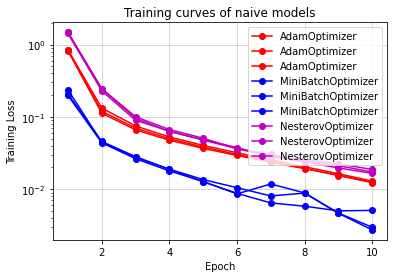

In [19]:
df_naive = pd.DataFrame(data_naive).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

Let's do some sanity check / monitoring:

In [20]:
df_naive['acc_mean'] = df_naive.acc_test.apply(lambda e: np.mean(e))
df_naive['acc_std'] = df_naive.acc_test.apply(lambda e: np.std(e))

In [21]:
df_naive.groupby(['optimizer'])[['acc_mean', 'acc_std']].agg('mean')

,acc_mean,acc_std
optimizer,,
AdamOptimizer,0.990149,0.019521
MiniBatchOptimizer,0.989089,0.012961
NesterovOptimizer,0.990413,0.014080


### Attack plots

In [22]:
df = pd.DataFrame(data_naive_attack).sort_values(['optimizer', 'epsilon'])
df.T.to_json('res/log_attack_naive.json', indent=2)

In [23]:
# Sanity check
df[df.epsilon== 0].groupby(['optimizer', 'attack']).acc.agg(['mean', 'std'])

mean       std
optimizer          attack                    
AdamOptimizer      fgsm    0.990149  0.000288
                   pgd     0.990149  0.000288
MiniBatchOptimizer fgsm    0.989089  0.001386
                   pgd     0.989089  0.001386
NesterovOptimizer  fgsm    0.990413  0.000663
                   pgd     0.990413  0.000663

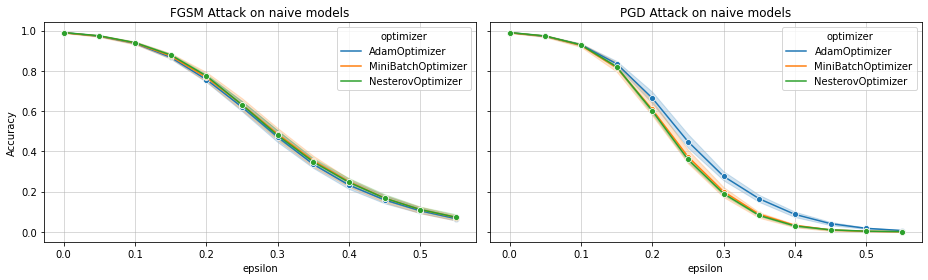

In [24]:
_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True, sharey=True)
plt.axes(ax[0])
sns.lineplot(x='epsilon', y='acc', data=df[df.attack == 'fgsm'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('FGSM Attack on naive models');

plt.axes(ax[1])
sns.lineplot(x='epsilon', y='acc', data=df[df.attack == 'pgd'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('PGD Attack on naive models');
plt.tight_layout()

# Attack on robust model

## Hyperparameter optimization on robust models


### Adam

In [25]:
search_grid_adam = {
    'lr': np.linspace(0.001, 0.01, 2),
    'beta1':  np.linspace(0.1, 0.9, 2),
    'beta2': np.linspace(0.5, 0.999, 2),
    'batch_size': [32, 64, 128],
    'weight_decay': np.linspace(0.001, 0.1, 2),
    'epsilon': np.linspace(1e-10, 1e-8, 2),
}

if prot_hyperparameter_tune:
    results_adam_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        func=protected_training,
        **training_config)
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_adam_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_adam_prot, f, indent=2)

### Nesterov

In [27]:
search_grid_nesterov = {
    'lr': np.logspace(0, 1),
    'batch_size': [32, 64, 128]
}

if prot_hyperparameter_tune:
    results_nesterov_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        func=protected_training,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_nesterov_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_nesterov_prot, f, indent=2)

### Minibatch

In [29]:
search_grid_mini  = {
    'lr': np.linspace(0.00001, 0.01, 5),
    'batch_size': [32, 64, 128],
    'decreasing_lr': [0, 1],
}

if prot_hyperparameter_tune:
    results_mini_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,                           
        search_grid=search_grid_mini,
        nfolds=3,
        func=protected_training,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_minibatch_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_mini_prot, f, indent=2)

### Load results

In [30]:
prot_optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/prot_res_adam_new1.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/prot_res_nesterov_new1.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/prot_minibatch_tuning.json', get_performance=False)
}

In [31]:
prot_optimizers

{optimizer.AdamOptimizer: {'lr': 0.001,
  'beta1': 0.9,
  'beta2': 0.999,
  'weight_decay': 0.001,
  'epsilon': 1e-10,
  'batch_size': 128},
 optimizer.NesterovOptimizer: {'lr': 1.0, 'batch_size': 128},
 optimizer.MiniBatchOptimizer: {'lr': 0.12589254117941673,
  'decreasing_lr': False,
  'batch_size': 128}}

## Train & Attack robust models

In [32]:
from adversary import protected_training

In [33]:
# Logging data structures
data_robust = list()
data_robust_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in prot_optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = protected_training(
            model=net,
            dataset=train_loader,
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_robust.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            # Attack 1
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_robust_attack.append({
                'optimizer': str(optimizer_instance),
                'attack': 'fgsm',
                'n': n,
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
            # Attack 2            
            print('', end='.')
            loss_attack, acc_attack = projected_attack(model=net,
                                                       test_loader=test_loader, 
                                                       epsilon=eps, 
                                                       alpha=0.01, 
                                                       num_iter=40,
                                                       verbose=False,
                                                       **test_config)
            # Log
            data_robust_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'pgd',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
        print()

--- AdamOptimizer
. . . . . . . . . . training took 20.16 s
Avg test loss = 0.0362	Avg test acc = 0.991
Launching attacks ........................
. . . . . . . . . . training took 19.31 s
Avg test loss = 0.0257	Avg test acc = 0.992
Launching attacks ........................
. . . . . . . . . . training took 20.17 s
Avg test loss = 0.0288	Avg test acc = 0.991
Launching attacks ........................
--- NesterovOptimizer
. . . . . . . . . . training took 17.09 s
Avg test loss = 2.31	Avg test acc = 0.102
Launching attacks ........................
. . . . . . . . . . training took 17.82 s
Avg test loss = 2.31	Avg test acc = 0.102
Launching attacks ........................
. . . . . . . . . . training took 17.22 s
Avg test loss = nan	Avg test acc = 0.0976
Launching attacks ........................
--- MiniBatchOptimizer
. . . . . . . . . . training took 16.85 s
Avg test loss = 0.0283	Avg test acc = 0.991
Launching attacks ........................
. . . . . . . . . . training took 16.86 

### Training curves

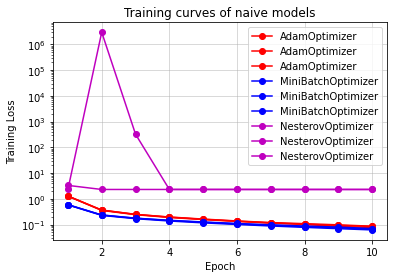

In [34]:
df_naive = pd.DataFrame(data_robust).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

### Attack plots

In [35]:
df_robust = pd.DataFrame(data_robust_attack).sort_values(['optimizer', 'epsilon'])
df_robust.T.to_json('res/log_attack_robust.json', indent=2)

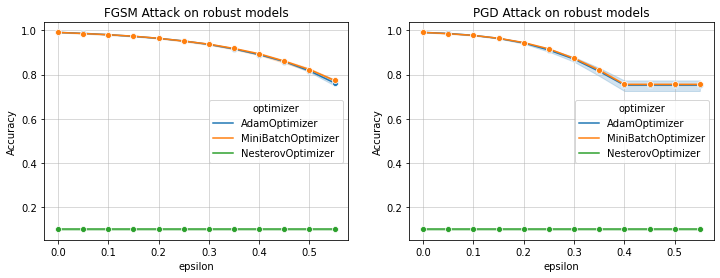

In [36]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.axes(ax[0])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df_robust[df_robust.attack == 'fgsm'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('FGSM Attack on robust models');

plt.axes(ax[1])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df_robust[df_robust.attack == 'pgd'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('PGD Attack on robust models');

# Comparative analysis

In [37]:
%%capture --no-stderr
# Whether to generate fancy plots for the report. Warning: this lengthens image rendering time
# This requires the `ipypublish` library
fancy_plots = True

if fancy_plots:
    from ipypublish import nb_setup
    plt = nb_setup.setup_matplotlib()
    # Override with seaborn defaults
    sns.set(style='whitegrid')

/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWa

In [38]:
from pathlib import Path

fig_path = Path('fig')
if not fig_path.exists():
    fig_path.mkdir()

In [39]:
df_naive = pd.read_json('res/log_attack_naive.json').T
df_robust = pd.read_json('res/log_attack_robust.json').T
# For some reason this has to be done after parsing from json
df_naive.epsilon = df_naive.epsilon.astype(float)
df_naive.acc = df_naive.acc.astype(float)
df_robust.acc = df_robust.acc.astype(float)
df_robust.epsilon = df_robust.epsilon.astype(float)

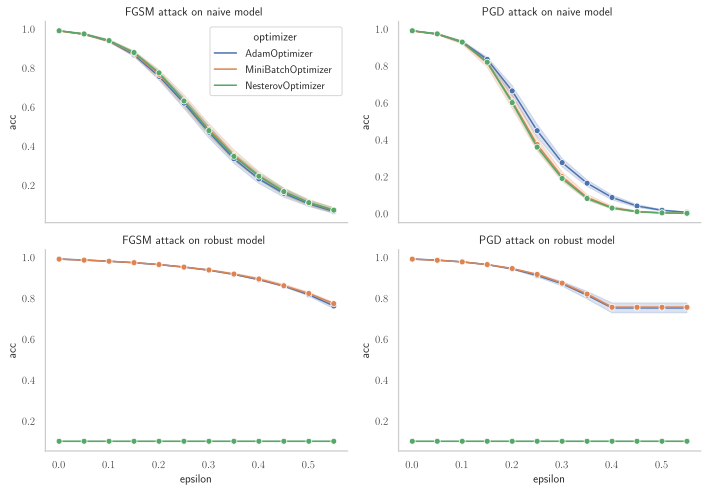

In [40]:
_, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

plot_config = [
    [df_naive, ('FGSM', 'naive'), ('PGD', 'naive')],
    [df_robust, ('FGSM', 'robust'), ('PGD', 'robust')]
]

for i, row in enumerate(plot_config):
    df = row[0]
    for j, (attack, naiveness) in enumerate(row[1:]):
        plt.axes(ax[i, j])
        sns.lineplot(x='epsilon', y='acc', data=df[df.attack == attack.lower()], hue='optimizer', marker='o', ci='sd')
        ax[i, j].set_title(f'{attack} attack on {naiveness} model')
        ax[i, j].grid(alpha=.5)
        
        if not (i == 0 and j == 0):
            ax[i, j].legend_.remove()
            
plt.tight_layout()
sns.despine()

In [41]:
join_on = ['optimizer', 'attack', 'epsilon', 'n']
df_compare = df_naive.rename(columns={'acc': 'acc_naive'}).drop(columns=['loss']) \
                     .join(df_robust.rename(columns={'acc': 'acc_robust'})\
                                    .set_index(join_on)\
                                    .drop(columns=['loss']), on=join_on)

df_compare['delta'] = df_compare.acc_robust - df_compare.acc_naive
df_compare

,optimizer,n,attack,epsilon,acc_naive,acc_robust,delta
0,AdamOptimizer,1,fgsm,0.00,0.990315,0.990605,0.000290
1,AdamOptimizer,1,pgd,0.00,0.990315,0.990605,0.000290
24,AdamOptimizer,2,fgsm,0.00,0.990315,0.991693,0.001378
25,AdamOptimizer,2,pgd,0.00,0.990315,0.991693,0.001378
48,AdamOptimizer,3,fgsm,0.00,0.989816,0.991199,0.001382
...,...,...,...,...,...,...,...
95,NesterovOptimizer,1,pgd,0.55,0.000597,0.102354,0.101757
118,NesterovOptimizer,2,fgsm,0.55,0.064490,0.102354,0.037863
119,NesterovOptimizer,2,pgd,0.55,0.000896,0.102354,0.101458
142,NesterovOptimizer,3,fgsm,0.55,0.087480,0.097607,0.010127


Text(0, 0.5, 'Improved robusteness')

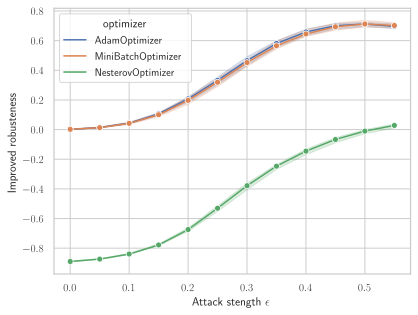

In [42]:
sns.lineplot(x='epsilon', y='delta', data=df_compare[df_compare.attack=='fgsm'], hue='optimizer', marker='o')
plt.xlabel('Attack stength $\epsilon$')
plt.ylabel('Improved robusteness')

Text(0, 0.5, 'Improved robusteness')

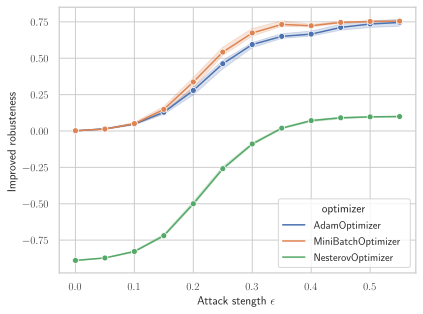

In [43]:
sns.lineplot(x='epsilon', y='delta', data=df_compare[df_compare.attack=='pgd'], hue='optimizer', marker='o')
plt.xlabel('Attack stength $\epsilon$')
plt.ylabel('Improved robusteness')